**POZNÁMKA: Tento notebook je určený pre platformu Google Colab. Je však možné ho spustiť (možno s drobnými úpravami) aj ako štandardný Jupyter notebook.** 



In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Ellipse
from IPython.utils.capture import capture_output
from scipy.spatial import distance_matrix
from IPython.display import display, HTML

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
point_color = (0, 0, 1)
active_point_color = (0.3, 0.3, 1)
cluster_color = (0.4, 0.4, 0.7)
active_cluster_color = (0.6, 0.6, 0.8)

def make_ellipse(pointA, pointB, color=active_cluster_color,
                 alpha=0.3, ax=None):
    if ax is None:
        ax = plt.gca()
        
    if pointA[1] < pointB[1]:
        pointA, pointB = pointB, pointA
    
    ABdist = np.linalg.norm(pointA - pointB)
    center = (pointA + pointB) / 2
    angle = np.arccos((pointA[0] - pointB[0]) / ABdist) / np.pi*180
                       
    ellipse = Ellipse(
        xy=center, width=ABdist + 10,
        height=(ABdist + 10)/2, angle=angle,
        alpha=alpha, facecolor=color
    )
    
    ax.add_artist(ellipse)

def point_sizes(point_counts):
    """
    An auxiliary function for calculating the point sizes.
    """
    return (point_counts - 1)*100 + 50

def plot_data(data, color=point_color, ax=None,
              labels='ABCDEFGHIJKLMNOPQRSTUVXYZ',
              c=None, s=50):
    if ax is None:
        ax = plt.gca()

    if c is None:
        ax.scatter(data[:, 0], data[:, 1], s=s, color=color)
    else:
        ax.scatter(data[:, 0], data[:, 1], s=s, c=c)
        
    for i in range(data.shape[0]):
        if not labels[i] is None and len(labels[i]) != 0:
            ax.annotate(labels[i], xy=(data[i, 0], data[i, 1]),
                        xytext=(data[i, 0] - 1, data[i, 1] + 2))
    
    ax.set_aspect('equal')
    ax.grid(ls='--')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_axisbelow(True)

class DummyContext:
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        pass

def plot_hierarchical_clustering(
    data, linkage_method='centroid',
    figsize=(6, 5),
    fig_fname_step='output/hierarchical_algo_{}.svg',
    fig_fname_dendrogram='output/hierarchical_algo_dendrogram.svg',
    show_steps_inline=True,
    show_dendrogram_inline=True,
    point_color=point_color,
    cluster_color=cluster_color,
    active_point_color=active_point_color,
    active_cluster_color=active_cluster_color,
    labels='ABCDEFGHIJKLMNOPQRSTUVXYZ'
):
    # we compute the distance matrix
    D = squareform(squareform(pdist(data)))
    # we compute the linkage matrix
    Y = sch.linkage(D, method=linkage_method)
    
    deleted = set()
    points = list(data.copy())
    points_count = [1 for i in range(data.shape[0])]
    figs = []

    xlim = None
    ylim = None
    
    with DummyContext() if show_steps_inline else capture_output():
        # go over each row of the linkage matrix
        for Y_row_i, (p1, p2, _, _) in enumerate(Y):
            fig = plt.figure(figsize=figsize)
            figs.append(fig)
            p1 = int(p1); p2 = int(p2)

            # mark p1 and p2 as deleted to suppress them in further plots
            deleted.add(p1)
            deleted.add(p2)

            # gather the points to be plotted
            to_plot = []
            to_plot_labels = []
            colors = []

            for i in range(len(points)):
                if not i in deleted:
                    to_plot.append(i)
                    
                    if i < len(data):
                        to_plot_labels.append(labels[i])
                    else:
                        to_plot_labels.append(None)

                    # different colors for original points and for clusters
                    if i >= data.shape[0]:
                        colors.append(cluster_color)
                    else:
                        colors.append(point_color)

            # compute the weight (number of points) of the new cluster
            points_count.append(points_count[int(p1)] + points_count[int(p2)])
            # add the new cluster into the list of points
            points.append((points[int(p1)] * points_count[int(p1)] +
                          points[int(p2)] * points_count[int(p2)]) / points_count[-1])

            # plot the gathered points
            ar_points = np.asarray(points)
            plot_data(ar_points[to_plot, :], labels=to_plot_labels, c=colors,
                      s=point_sizes(np.asarray(points_count)[to_plot]))
            
            # plot the active points in a different color and plot the new cluster
            # as an ellipse and its centroid as a cross
            plt.scatter(ar_points[[p1, p2], 0], ar_points[[p1, p2], 1],
                        color=active_point_color,
                        s=point_sizes(np.asarray(points_count)[[p1, p2]]), lw=0)
            plt.scatter(ar_points[-1, 0], ar_points[-1, 1], c='r',
                        marker='+', s=50)
            make_ellipse(points[p1], points[p2], ax=plt.gca(),
                         color=active_cluster_color)

            if xlim is None:
                xlim = plt.gca().get_xlim()
                ylim = plt.gca().get_ylim()
            else:
                plt.gca().set_xlim(xlim)
                plt.gca().set_ylim(ylim)

            plt.gca().set_aspect('equal')
            plt.show()

            if not fig_fname_step is None:
                fig.savefig(fig_fname_step.format(Y_row_i),
                            bbox_inches='tight', pad_inches=0)
    
        # display the final cluster
        fig = plt.figure(figsize=figsize)
        figs.append(fig)
        plt.grid(ls='--')
        ar_points = np.asarray(points)
        plot_data(ar_points[-1:, :], color=cluster_color, labels=[None],
                  s=(np.asarray(points_count)[-1] - 1)*100 + 50)

        if not xlim is None:
            plt.gca().set_xlim(xlim)
            plt.gca().set_ylim(ylim)
            
        plt.gca().set_aspect('equal')
        plt.show()

        if not fig_fname_step is None:
            fig.savefig(fig_fname_step.format('final'),
                        bbox_inches='tight', pad_inches=0)

    with DummyContext() if show_dendrogram_inline else capture_output():
        # display the dendrogram
        fig = plt.figure(figsize=figsize)
        figs.append(fig)
        G = sch.dendrogram(Y, color_threshold=0, labels=labels[:data.shape[0]])
        plt.grid(ls='--')
        plt.ylabel("distance")
        plt.show()

        if fig_fname_dendrogram:
            fig.savefig(fig_fname_dendrogram,
                        bbox_inches='tight', pad_inches=0)
    
    return figs

def display_distance_matrix(
    data, labels='ABCDEFGHIJKLMNOPQRSTUVXYZ', return_matrix=False,
    number_format='{:.2f}'
):
    dmat = distance_matrix(data, data)

    # print dmat as an HTML table
    html_table = "<table>"

    html_table += "<tr><th></th>"
    for i in range(data.shape[0]):
        html_table += "<th><strong>" + labels[i] + "</strong></th>"
    html_table += "</tr>"

    # find the row and the column with the minimum distance using argmin
    dmat[np.diag_indices(dmat.shape[0])] = None
    min_row, min_col = np.unravel_index(np.nanargmin(dmat), dmat.shape)

    for i in range(dmat.shape[0]):
        html_table += "<tr><td><strong>{}</strong></td>".format(labels[i])
        for j in range(dmat.shape[1]):
            if i == j:
                html_table += "<td>-</td>"

            elif i < j:
                if (i == min_row and j == min_col) or (i == min_col and j == min_row):
                    html_table += ("<td><strong>" + number_format + "</strong></td>").format(dmat[i, j])
                else:
                    html_table += ("<td>" + number_format + "</td>").format(dmat[i,j])

            else:
                html_table += "<td></td>"
            
        html_table += "</tr>"
        
    html_table += "</table>"

    # display the table in the notebook
    display(HTML(html_table))

    if return_matrix:
        return dmat

## Hierarchické zhlukovanie

V ďalšej časti sa budeme venovať hierarchickému zhlukovaniu: medzi jeho výhody patrí relatívna jednoduchosť, fakt, že nie je obmedzené na euklidovské priestory a tiež, že poskytuje veľmi prirodzený spôsob, ako vizualizovať štruktúru zhlukov pomocou tzv. **dendrogramu** . Platí tiež, že počet zhlukov nie je potrebné definovať vopred. Na druhej strane, hlavnou nevýhodou hierarchického zhlukovania je vysoká výpočtová náročnosť kvôli ktorej sa nehodí na prácu s veľkými dátovými množinami.

V rámci hierarchického zhlukovania existujú dve paradigmy [[ESL]](#ESL):

* aglomeratívna (zdola nahor);
* divizívna (zhora nadol).
V aglomeratívnom zhlukovaní (t.j. zdola nahor) začína proces na najnižšej úrovni [[ESL]](#ESL):

# Každý bod sa priradí do svojho vlastného zhluku.
# Nájde sa pár zhlukov, ktoré sú si vzájomne najbližšie.
# Nájdený pár sa spojí do nového väčšieho zhluku.
# Kroky 2 a 3 sa opakujú kým všetky sa body nespoja do jedného spoločného zhluku.
Princíp je vysvetlený o niečo formálnejším spôsobom aj v algoritme nižšie.

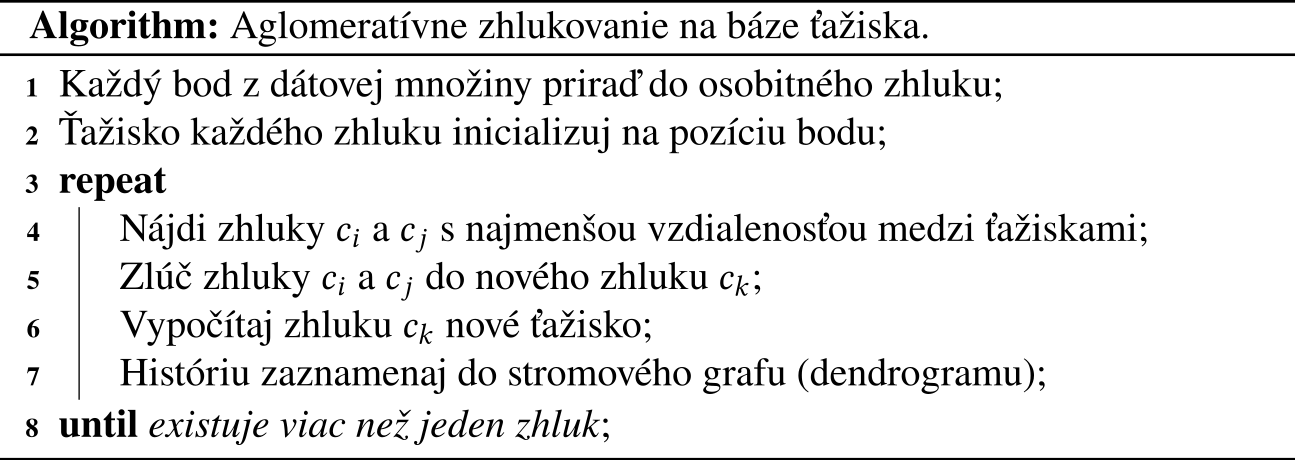

Pri divizívnom zhlukovaní by sme postupovali opačným smerom: začali by sme s jedným zhlukom, ktorý by sme postupne delili na menšie až kým by každý zhluk neobsahoval len jeden bod. Zhluky by sa delili tak, aby sa maximalizoval nejaký druh vzdialenosti medzi novo vzniknutými podzhlukmi.

### Vizuálny príklad

Ďalej si ukážeme vizuálnu ilustráciu celého procesu na jednoduchom 2-rozmernom príklade. Vytvorme si najprv malú dátovú množinu:



In [ ]:
data = np.array([
    [119.76 , 136.   ],
    [172.26 , 141.   ],
    [149.775, 116.   ],
    [ 82.275,  71.   ],
    [ 48.51 ,  56.   ],
    [ 76.5  ,  51.   ]
])

In [ ]:
fig = plt.figure(figsize=(6, 5))
plot_data(data)

Ako sme už povedali, v prvom kroku vyberie zhlukovacia procedúra dva body medzi ktorými je najnižšia vzdialenosť a tie spojí do znového zhluku. Pozrime sa, ktoré body by to v našom prípade boli – zobrazme si euklidovské vzdialenosti medzi všetkými bodmi a zvýraznime najmenšiu z nich.



In [ ]:
display_distance_matrix(data)

Zdá sa, že najmenšia je vzdialenosť medzi bodmi D a F, takže tieto by sme mali spojiť ako prvé. Nasledujúca bunka zobrazí všetky jednotlivé kroky procedúry zhlukovania. Porovnajte či prvý zhluk s 2 bodmi skutočne tvoria body D a F.



In [ ]:
figs = plot_hierarchical_clustering(data, show_dendrogram_inline=False)

A napokon si zobrazme aj dendrogram opisujúci hierarchickú štruktúru výsledného zhlukovania. Spolu s dendrogramom vykreslíme znovu aj pôvodnú dátovú množinu, aby bolo možné ľahšie porovnať, ktoré body sa zlúčili dokopy a v akom poradí.

Všimnite si, že dendrogram, ktorý tu zobrazujeme, sme vytvorili pomocou vlastnej funkcie určenej len na demonštráciu. V neskoršom notebook-u si ukážeme, ako realizovať hierarchické zhlukovanie v praxi a tiež ako k nemu zostaviť dendrogram a ďalšie druhy sprievodných vizualizácií.



In [ ]:
display(figs[-1])
plot_data(data)

### Hierarchické zhlukovanie v neuklidovských priestoroch

V našom malom demonštračnom príklade sme predpokladali, že každý zhluk bude reprezentovaný svojím ťažiskom a vzdialenosti medzi zhlukmi sa budú určovať ako euklidovské vzdialenosti medzi týmito ťažiskami. Toto by bolo pochopiteľne problematické ak priesto, v ktorom pracujeme, je neuklidovský, vzdialenosti sú definované iným spôsobom a výpočet ťažiska ani nedáva zmysel – výsledkom by ani nemusel byť validný bod patriaci do daného priestoru.

V takých priestoroch by sme si mohli zvoliť stratégiu, ktorú používa algoritmus $k$-medoids a vybrať na reprezentáciu zhluku bod, ktorý je v určitom zmysle najviac reprezentatívny. Keď však vezmeme do úvahy, že jediné, čo potrebujeme, je spôsob ako vyrátať vzdialenosť medzi dvoma zhlukmi, častejším riešením býva zvoliť vzdialenostnú metriku, ktorá nevychádza z predpokladu, že priestor je euklidovský.

Jedna vec, ktorú môžeme vždy urobiť, je vypočítať ľubovoľný typ vzdialenosti medzi jednotlivými bodmi z oboch zhlukov. Následne sa potom môžeme rozhodnúť, ktorú z týchto vzdialeností použijeme na určenie celkovej vzdialenosti medzi zhlukmi. Existuje viacero často používaných prístupov – ak preskúmate rozhranie [triedy `AgglomerativeClustering` v dokumentácii scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), uvidíte, že je možné jeden z nich zvoliť prostredníctvom argumentu `linkage`.

V každom prípade, ak sme teda už vypočítali vzdialenosti medzi všetkými pármi bodov z prvého a druhého zhluku, môžeme použiť napr. [[mmds2014]](#mmds2014):

* **Maximálnu vzdialenosť (complete, resp. maximum linkage)** ;
* **Minimálnu vzdialenosť (single linkage)** ;
* **Priemernú vzdialenosť (average linkage)** ;
Medzi ďalšie alternatívy patrí možnosť skúsiť spojiť zhluky dokopy, určiť výsledné rozptyly a zvoliť možnosť, ktorá minimalizuje rozptyl nového zhluku [[mmds2014]](#mmds2014). Tento prístup sa niekedy označuje termínom **ward linkage**  a v rámci balíčka scikit-learn ide o **predvolený prístup** .



### References

<a id="ESL">[ESL]</a> Hastie, T. – Tibshirani, R. – Friedman, J. The Elements of Statistical Learning. Springer, 2009, second edition. ISBN 978-0-387-84858-7.

<a id="mmds2014">[mmds2014]</a> Rajaraman, A. and Ullman, J.D., 2011. Mining of massive datasets. Cambridge University Press. URL: <http://infolab.stanford.edu/~ullman/mmds/book.pdf>.



In [ ]:
latex_out = latex2svg(r"""
\begin{algorithm}[H]
Assign each dataset point into a separate cluster\;
Initialize the centroid of each cluster to the point's position\;

\Repeat{more than one cluster exists}{
Find clusters $c_i$ and $c_j$ with the shortest centroid-to-centroid distance\;
Join clusters $c_i$ and $c_j$ into a new cluster $c_k$\;
Compute the new centroid of cluster $c_k$\;
Record the history of the join into the dendrogram\;
}

\caption{Centroid-based agglomerative clustering.}
\label{alg:agglomerative_clustering}
\end{algorithm}
""", params=params
)

with open("gen_images/agglomerative_clustering.svg", "w") as file:
    file.write(latex_out['svg'])
    
display(SVG(latex_out['svg']))